# Imports

In [ ]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [ ]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [ ]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

## Load Test Set

In [ ]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

# Pre-Process DataSet

In [ ]:
# pre-process data 
def scale_pixels(train, val, test):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm

# Plot Diagnostics

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

# Create CNN Model

In [ ]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [ ]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # prepare pixel data
  X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return accuracy

Epoch 1/75
157/157 [==============================] - 536s 3s/step - loss: 0.6892 - accuracy: 0.5750 - val_loss: 0.5787 - val_accuracy: 0.6305
Epoch 2/75
157/157 [==============================] - 534s 3s/step - loss: 0.5017 - accuracy: 0.7801 - val_loss: 0.5056 - val_accuracy: 0.7725
Epoch 3/75
157/157 [==============================] - 532s 3s/step - loss: 0.4355 - accuracy: 0.8283 - val_loss: 0.4239 - val_accuracy: 0.8255
Epoch 4/75
157/157 [==============================] - 530s 3s/step - loss: 0.3727 - accuracy: 0.8597 - val_loss: 0.3231 - val_accuracy: 0.8750
Epoch 5/75
157/157 [==============================] - 532s 3s/step - loss: 0.3481 - accuracy: 0.8646 - val_loss: 0.2901 - val_accuracy: 0.8925
Epoch 6/75
157/157 [==============================] - 533s 3s/step - loss: 0.2975 - accuracy: 0.8883 - val_loss: 0.2785 - val_accuracy: 0.8945
Epoch 7/75
157/157 [==============================] - 530s 3s/step - loss: 0.2730 - accuracy: 0.8931 - val_loss: 0.2312 - val_accuracy: 0.9060

0.9614999890327454

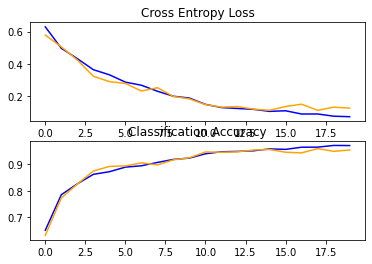

In [ ]:
train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)

## Train Data with Data Augmentation

In [ ]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # prepare pixel data
  X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return accuracy

Epoch 1/100
156/156 [==============================] - 708s 5s/step - loss: 0.6795 - accuracy: 0.5788 - val_loss: 0.5717 - val_accuracy: 0.7170
Epoch 2/100
156/156 [==============================] - 701s 4s/step - loss: 0.5496 - accuracy: 0.7292 - val_loss: 0.4563 - val_accuracy: 0.8045
Epoch 3/100
156/156 [==============================] - 691s 4s/step - loss: 0.4444 - accuracy: 0.8178 - val_loss: 0.3401 - val_accuracy: 0.8755
Epoch 4/100
156/156 [==============================] - 696s 4s/step - loss: 0.3894 - accuracy: 0.8490 - val_loss: 0.3747 - val_accuracy: 0.8500
Epoch 5/100
156/156 [==============================] - 693s 4s/step - loss: 0.3459 - accuracy: 0.8577 - val_loss: 0.2813 - val_accuracy: 0.8855
Epoch 6/100
156/156 [==============================] - 723s 5s/step - loss: 0.2893 - accuracy: 0.8866 - val_loss: 0.3186 - val_accuracy: 0.8740
Epoch 7/100
156/156 [==============================] - 700s 4s/step - loss: 0.2596 - accuracy: 0.8943 - val_loss: 0.2316 - val_accuracy:

0.9490000009536743

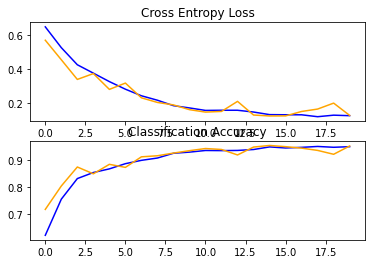

In [ ]:
train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)